# 2R Roboter

## Simulation nichtlineares Modell ohne Eingang

In [ ]:
"""
Date: 20.12.2022
Author: Kaufmann Stefan

Robot Control - Simulation 2R Roboter 
"""
# Load Robotermodell
import numpy as np
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
from Model import model_nlin, model_nlin_ext
import importlib as imp


In [ ]:
from Model import model_nlin, model_nlin_ext
# set the initial conditions
x0=[-np.pi/2*0,0,0,np.pi/4]

# define the discretization points
t_start = 0
t_stop = 10
dt = 1e-1

t_sim=np.linspace(t_start, t_stop, int((t_stop - t_start) / dt + 1))

class Controller:
  def __init__(self,u,t_sim):
    self.ctr = 'NONE'
    self.t  = t_sim
controller = Controller(0,t_sim)


#Wrapper für rechte Seite der Differentialgleichung
rhs=lambda t,x:model_nlin_ext(t,x,controller)
    
solOde = solve_ivp(rhs,                  #zu simulierendes Modell
                    [t_start,t_stop],    #Zeitspanne für Simulation
                    x0,                  #Anfangszustand 
                    t_eval=t_sim,        #Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6  #Toleranzen
                    )


plt.plot(solOde.t, solOde.y[0]*180/np.pi, 'b', label='q_1')
plt.plot(solOde.t, solOde.y[2]*180/np.pi, 'g', label='q_2')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('q1(t), q2(t)')
plt.grid()
#plt.savefig('simulation.png')
plt.show()

In [ ]:
import Animation as anim

q1 = solOde.y[0]
q2 = solOde.y[2]
anim.plot(q1,q2,dt)


# Vorsteuerung

In [ ]:
from Vorsteuerung import *
#from Parameter  import *

u = flat_output(t_stop,t_sim,3,x0[0],0)

plt.plot(t_sim,u[0,:])
plt.plot(t_sim,u[1,:])
plt.plot(t_sim,u[2,:])
plt.legend(['q','q_d','q_dd'])
plt.grid()
plt.show()





## Multivariable Control (Inverse Dynamik)

In [ ]:
import Animation as anim
import numpy as np
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
from Model import model_nlin, model_nlin_ext
from Vorsteuerung import *

x0=[-np.pi/2,0,0,np.pi/4]       # x0 = [q1,q2,qd1,qd2]

# define the discretization points
t_start = 0
t_stop = 10
dt = 1e-1

t_sim=np.linspace(t_start, t_stop, int((t_stop - t_start) / dt + 1))

# Define the controller
class Controller:
  def __init__(self,u,t_sim):
    import sympy as sym
    from Vorsteuerung import flat_output
    self.w1 = 10
    self.w2 = 10
    self.ctr = 'multivariable'
    self.trn = False
    self.k0 = sym.Matrix([[self.w1**2, 0],[0, self.w2**2]])
    self.k1 = sym.Matrix([[2*self.w1, 0],[0, 2*self.w2]])
    self.u  = u
    self.t  = t_sim

# Define the input vector
u1 = flat_output(t_stop,t_sim,3,x0[0],0)
u2 = flat_output(t_stop,t_sim,3,0,np.pi)

u= np.vstack((u1[0,:],u2[0,:],u1[1,:],u2[1,:],u1[2,:],u2[2,:]))

controller = Controller(u,t_sim)

#Wrapper für rechte Seite der Differentialgleichung
rhs=lambda t,x:model_nlin_ext(t,x,controller)
    
solOde = solve_ivp(rhs,                  #zu simulierendes Modell
                    [t_start,t_stop],    #Zeitspanne für Simulation
                    x0,                  #Anfangszustand 
                    t_eval=t_sim,        #Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6  #Toleranzen
                    )


plt.plot(solOde.t, solOde.y[0]*180/np.pi, 'b', label='q_1')
plt.plot(solOde.t, solOde.y[1]*180/np.pi, 'g', label='q_2')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('q1(t), q2(t)')
plt.grid()
#plt.savefig('simulation.png')
plt.show()

q1 = solOde.y[0]
q2 = solOde.y[1]
anim.plot(q1,q2,dt)


## Transformation 
### Kartesische Koordinaten in den Gelenkswinkelraum

$   \vec{\dot{X}} = J_{a(q)} \dot{q}   $  
mit  
$J_{a(q)} = 	
\begin{bmatrix} 
	I & 0 \\
	0 & B^{-1}(\alpha)
\end{bmatrix}
J(q)  $  

$J(q)\dot{q} = 
\begin{bmatrix}
\dot{x} \\ \dot{y} \\ \dot{z} \\
\dot{\omega_{x}} \\ \dot{\omega_{y}} \\ \dot{\omega_{z}} 
\end{bmatrix}$


$J(a)\dot{q} = 
\begin{bmatrix}
\dot{x} \\ \dot{y} \\ \dot{z} \\
\dot{\omega_{x}} \\ \dot{\omega_{y}} \\ \dot{\omega_{z}} 
\end{bmatrix}$





In [ ]:
from Kinematik_2R import *

#display('B=', B_a)  #= sym.Matrix([[sym.cos(Psi)*sym.cos(Theta),-sym.sin(Theta), 0],[sym.sin(Psi)*sym.sin(Theta), sym.cos(Psi), 0],[sym.cos(Theta), 0, 1]])

#display('J(q) = ',J) #= Jv_2.col_join(sym.zeros(1,2)).col_join(Jw_2)

#X = sym.eye(3).col_join(sym.zeros(3,3))
#display('X=',X) #= X.row_join(sym.zeros(3,3).col_join(B_a))
display('Ja = ',Ja) #= X * J


a = np.matrix([[0.5,0.5,0,0,0,0]])



### Analytische Jacobimatrix

In [ ]:
'''Vorwärtskinematik'''
from Kinematik_2R import *
import Parameter as param

# Für Nummerische Berechnung T0e
# Für symbolische Berechnung T03sub    --> nicht bei der Inversen Matrix zu empfehlen --> hoher Rechenaufwand

T02_sub = T02.subs({a1:param.l1,a2:param.l2,alpha1:0, alpha2:0,d1:0,d2:0})
display(T02_sub)

# Reduzierung der Matrix auf die Position (erste Spalte)
T02_sub_ = T02_sub*sym.Matrix([1,0,0,0])

X_sub = T02_sub_.subs({q1:0, q2:np.pi/2})
display('X = ',X_sub[1:4])                            # Ausgabe  erste Ziele dient der homogenosierung X = [1, x, y, z]


''' Inverse Kinematik '''
x,y = 1, 1
X = sym.Matrix([1,x,y,0])                      # 1 dient der homogenisierung, z muss immer 0 sein, da der Roboter sich nur in der Ebene bewegen kann!

solution_set = sym.solve(T02_sub_-X, q1,q2, set = True)   # Berechnung dauert sehr lange, mitunter gibt es auch keine Lösung
display('Solution =' ,solution_set)  # Ausgabe



#q1,q2 = sym.symbols('q1, q2',  real=True)
Equation = sym.Eq(T02_sub_-X)
solution = sym.nonlinsolve(Equation, [q1, q2])

print(solution)  # Ausgabe



# Multivariable Control mit Transformation

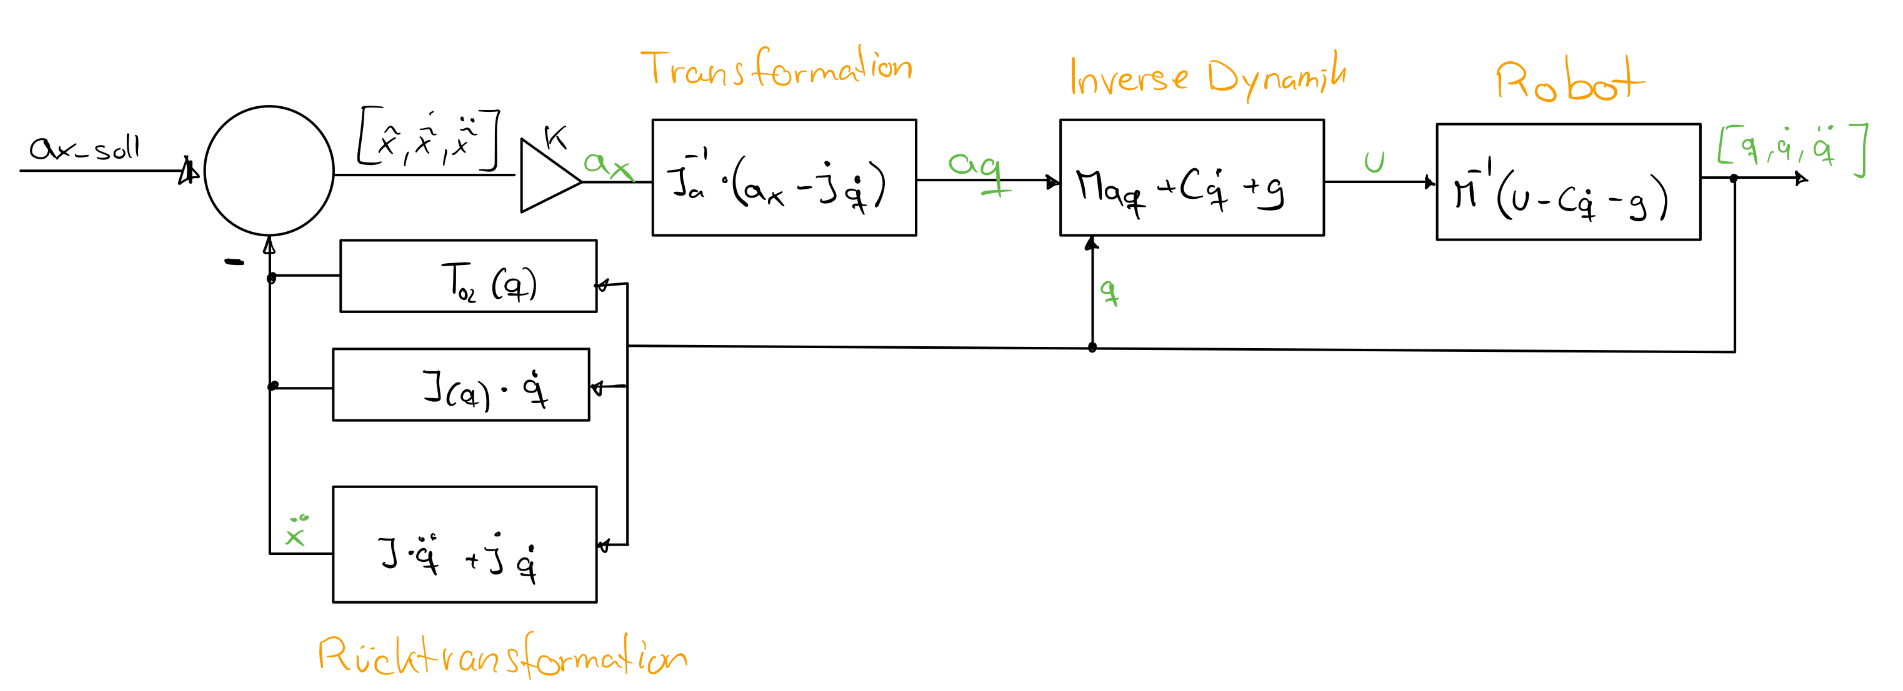

## Vorsteuerung 
- Berechnung der Startposition mit Hilfe der Inversen Kinematik.  
- Überprüfung der Start und Endpunkte (Erreichbarkeit)   
- Plotten der Trajektorie für eine Koordinate

In [ ]:

from Vorsteuerung import *

'''Vorwärtskinematik'''
from Kinematik_2R import T02, a1, a2, d1, d2, alpha1, alpha2 
import Parameter as param


T02_sub = T02.subs({a1:param.l1,a2:param.l2,alpha1:0, alpha2:0,d1:0,d2:0})

# Reduzierung der Matrix auf die Position (erste Spalte)
T02_sub_ = T02_sub*sym.Matrix([1,0,0,0])


''' Inverse Kinematik '''
# Überprüfung der Punkte und Berechnung der Startkonfiguration
x,y = np.array([1,1]), np.array([-1,1])

# Startpunkt
X = sym.Matrix([1,x[0],y[0],0])                                 # 1 dient der homogenisierung, z muss immer 0 sein, da der Roboter sich nur in der Ebene bewegen kann!
start = np.array(sym.solve(T02_sub_-X, q1,q2))                  # Berechnung dauert sehr lange, mitunter gibt es auch keine Lösung
display(start)

# Zielpunkt
X = sym.Matrix([1,x[1],y[1],0])                                 # 1 dient der homogenisierung, z muss immer 0 sein, da der Roboter sich nur in der Ebene bewegen kann!
ziel = np.array(sym.solve(T02_sub_-X, q1,q2)) 
display(ziel)



u = flat_output(t_stop,t_sim,3,y[0], y[1])

plt.plot(t_sim,u[0,:])
plt.plot(t_sim,u[1,:])
plt.plot(t_sim,u[2,:])
plt.legend(['y','y_d','y_dd'])
plt.grid()
plt.show()


# Multivariable Control

[0.0, 0.0, -3.8547714514835607, 0.708019246190858]
[-7.057652522686599e-06, 7.0754744290994024e-06, -3.8547653215029243, 0.7080100340297222]
[-0.00014115305045373197, 0.00014150948858198802, -3.854648849847019, 0.7078350064592737]
[-0.00021172776427995227, 0.00021226242478877404, -3.854587548988499, 0.7077428917160286]
[-0.000564599321017606, 0.0005660250972602407, -3.8542810304496102, 0.7072823481884585]
[-0.0006273309889407542, 0.0006289151878059403, -3.8542265363829604, 0.7072004799680297]
[-0.0007057451262471521, 0.0007075273540786672, -3.854158418001162, 0.7070981473187008]
[-0.0007057451258881959, 0.0007075273535747016, -3.8541584180014907, 0.7070981473193407]
[-0.002117195125503534, 0.0021225418831168565, -3.8529320661307964, 0.7052565533311276]
[-0.002822738993878106, 0.002829868357240377, -3.852318886281394, 0.7043362683628905]
[-0.006350257352410477, 0.006366300268846314, -3.849251563338098, 0.6997378598612058]
[-0.006977266647624849, 0.006994894512692171, -3.8487060733904728

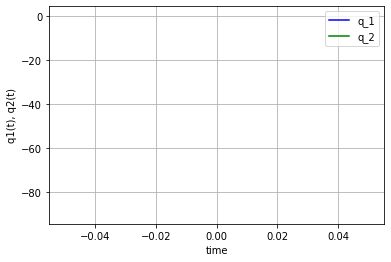

In [3]:
import Animation as anim
import numpy as np
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
from Model import model_nlin_ext
from Vorsteuerung import *

#x0=[start[0,0],start[0,1],0,0]       # x0 = [q1,q2,qd1,qd2]
x,y = np.array([1,1]), np.array([-1,1])
x0=[0,-np.pi/2,0,0]
# define the discretization points
t_start = 0
t_stop = 10
dt = 1e-1

t_sim=np.linspace(t_start, t_stop, int((t_stop - t_start) / dt + 1))

# Define the controller
class Controller:
  def __init__(self,ax,t_sim):
    import sympy as sym
    from Vorsteuerung import flat_output
    self.w1  = 20
    self.w2  = 20
    self.ctr = 'multivariable'                                      # Auswahl Reglertyp
    self.trn = True                                                # Soll die Transformation Kartesiche Gelenkraum eingeschalten werden?
    self.k0  = sym.Matrix([[self.w1**2, 0],[0, self.w2**2]])
    self.k1  = sym.Matrix([[2*self.w1, 0],[0, 2*self.w2]])    
    self.ax  = ax 
    self.aq  = np.array([0,0,0,0,0,0])
    self.u   = np.array([0,0])
    self.t   = t_sim

# Define the input vector
ax1 = flat_output(t_stop,t_sim,3,x[0],x[1])
ax2 = flat_output(t_stop,t_sim,3,y[0],y[1])

ax= np.vstack((ax1[0,:],ax2[0,:],ax1[1,:],ax2[1,:],ax1[2,:],ax2[2,:]))

controller = Controller(ax,t_sim)

#Wrapper für rechte Seite der Differentialgleichung
rhs=lambda t,x:model_nlin_ext(t,x,controller)
    
solOde = solve_ivp(rhs,                  #zu simulierendes Modell
                    [t_start,t_stop],    #Zeitspanne für Simulation
                    x0,                  #Anfangszustand 
                    t_eval=t_sim,        #Auswertungszeitpunkte
                    atol=1e-9,rtol=1e-6  #Toleranzen
                    )


plt.plot(solOde.t, solOde.y[0]*180/np.pi, 'b', label='q_1')
plt.plot(solOde.t, solOde.y[1]*180/np.pi, 'g', label='q_2')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('q1(t), q2(t)')
plt.grid()
#plt.savefig('simulation.png')
plt.show()

q1 = solOde.y[0]
q2 = solOde.y[1]
anim.plot(q1,q2,dt)
